## Cross-Genre Analysis- Word Frequency

In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn as sns#Makes plots look nice, also heatmaps
import scipy as sp 

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [2]:
lyrics_1 = pd.read_csv("cleaned_lyrics_1.csv")
lyrics_1['genre'] = lyrics_1['genre'].astype('category')

In [3]:
# code these genre names
genre_dict = {}
for i, c in enumerate(pd.unique(lyrics_1['genre'])):
    genre_dict[c] = i
genre_dict

{'Pop': 0,
 'Hip-Hop': 1,
 'Rock': 2,
 'Metal': 3,
 'Country': 4,
 'Jazz': 5,
 'Electronic': 6,
 'Folk': 7,
 'R&B': 8,
 'Indie': 9}

In [4]:
lyrics_1['genre'] = lyrics_1['genre'].apply(lambda x:genre_dict[x])

In [5]:
from sklearn.model_selection import train_test_split
# train_test split
lyrics_1_train, lyrics_1_test = train_test_split(lyrics_1, test_size=0.3, random_state=0)

In [6]:
# creating customized stop word lists
from sklearn.feature_extraction import stop_words
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS)
my_stop_words += [str(i) for i in range(10)]
my_stop_words += ['intro','verse','pre','post','lift','chorus','bridge',
                  'outro','instrumental','\[','\]',':',';','\\']
my_stop_words

['well',
 'within',
 'it',
 'yourselves',
 'fire',
 'toward',
 'serious',
 'always',
 'can',
 'we',
 'fifteen',
 'both',
 'again',
 'where',
 'whereupon',
 'never',
 'such',
 'four',
 'third',
 'been',
 'has',
 'next',
 'so',
 'ourselves',
 'front',
 'see',
 'must',
 'less',
 'whereas',
 'through',
 'somehow',
 'what',
 'around',
 'meanwhile',
 'others',
 'hundred',
 'do',
 'bill',
 'either',
 'even',
 'many',
 'show',
 'whereby',
 'they',
 'co',
 're',
 'last',
 'ltd',
 'any',
 'my',
 'themselves',
 'back',
 'three',
 'however',
 'beforehand',
 'same',
 'everywhere',
 'another',
 'give',
 'name',
 'several',
 'yours',
 'a',
 'sixty',
 'together',
 'thence',
 'hence',
 'here',
 'everyone',
 'thereby',
 'would',
 'whither',
 'often',
 'some',
 'out',
 'interest',
 'though',
 'among',
 'off',
 'onto',
 'were',
 'you',
 'into',
 'two',
 'whence',
 'seem',
 'became',
 'found',
 'rather',
 'twenty',
 'towards',
 'most',
 'seeming',
 'but',
 'one',
 'its',
 'take',
 'himself',
 'with',
 'eve

In [7]:
# Test Classifiaction 
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.8, min_df=0.01, stop_words=my_stop_words, norm='l2')
train_vects = TFVectorizer.fit_transform(lyrics_1_train['lyrics'])
train_vects.shape

(147449, 1023)

In [8]:
test_vects = TFVectorizer.transform(lyrics_1_test['lyrics'])
test_vects.shape

(63193, 1023)

In [9]:
pca = sklearn.decomposition.PCA(n_components=500)
train_pca = pca.fit_transform(train_vects.todense())

Text(0, 0.5, 'PVE')

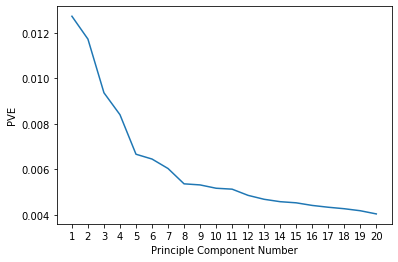

In [10]:
plt.plot(range(1,21), pca.explained_variance_ratio_[:20])
plt.xlabel('Principle Component Number')
plt.xticks(range(1,21))
plt.ylabel('PVE')

In [12]:
test_pca = pca.transform(test_vects.todense())
test_pca

array([[-0.00657813, -0.04109457,  0.08461245, ...,  0.00558358,
        -0.02193762, -0.01483977],
       [-0.10080945,  0.01093557,  0.02688712, ...,  0.07687371,
        -0.01577899,  0.01130262],
       [ 0.01002091,  0.0371978 , -0.05731673, ..., -0.03315517,
        -0.01735295, -0.00604899],
       ...,
       [ 0.11022017, -0.04610841,  0.45686384, ..., -0.00578458,
         0.00253869,  0.00388158],
       [-0.09221761,  0.02914313,  0.05033165, ..., -0.01619455,
        -0.00663203,  0.00203742],
       [-0.05624391,  0.02809515,  0.05114805, ...,  0.00164229,
         0.00060885, -0.0043226 ]])

In [11]:
# calculating sample weights for 
train_groups = lyrics_1_train.groupby(['genre'])
train_groups = dict(list(train_groups))

In [13]:
class_weights = {k:len(lyrics_1_train)/len(v) for k,v in train_groups.items()}
class_weights

{4: 14.898353036273619,
 6: 32.40637362637363,
 7: 125.16893039049236,
 1: 9.545478086359811,
 9: 71.1970062771608,
 5: 29.31974547623782,
 3: 10.074405575293795,
 0: 6.2238402768984,
 8: 64.4726716222125,
 2: 2.147430202583633}

In [14]:
class_bases = np.linspace(min(class_weights.values()),max(class_weights.values()),5)
class_bases

array([  2.1474302 ,  32.90280525,  63.6581803 ,  94.41355534,
       125.16893039])

In [15]:
class_weight_paras = []
for b in class_bases:
    candidate = {c:v+b for c,v in class_weights.items()}
    class_weight_paras.append(candidate)
class_weight_paras

[{4: 17.04578323885725,
  6: 34.553803828957264,
  7: 127.316360593076,
  1: 11.692908288943444,
  9: 73.34443647974443,
  5: 31.46717567882145,
  3: 12.221835777877429,
  0: 8.371270479482034,
  8: 66.62010182479614,
  2: 4.294860405167266},
 {4: 47.80115828583443,
  6: 65.30917887593444,
  7: 158.0717356400532,
  1: 42.44828333592062,
  9: 104.09981152672161,
  5: 62.222550725798634,
  3: 42.97721082485461,
  0: 39.126645526459214,
  8: 97.37547687177332,
  2: 35.05023545214445},
 {4: 78.55653333281163,
  6: 96.06455392291163,
  7: 188.82711068703037,
  1: 73.20365838289781,
  9: 134.8551865736988,
  5: 92.97792577277582,
  3: 73.73258587183179,
  0: 69.88202057343639,
  8: 128.1308519187505,
  2: 65.80561049912163},
 {4: 109.3119083797888,
  6: 126.81992896988882,
  7: 219.58248573400755,
  1: 103.95903342987499,
  9: 165.61056162067598,
  5: 123.733300819753,
  3: 104.48796091880898,
  0: 100.63739562041359,
  8: 158.8862269657277,
  2: 96.56098554609882},
 {4: 140.06728342676598,


In [16]:
# calculating sample weights for imbalanced sample
from sklearn.utils.class_weight import compute_sample_weight
train_sample_weights = compute_sample_weight(class_weight='balanced', y=lyrics_1_train['genre'])
train_sample_weights

array([0.62238403, 0.21474302, 0.62238403, ..., 0.21474302, 0.21474302,
       1.00744056])

In [17]:
sample_bases = np.linspace(min(train_sample_weights),max(train_sample_weights),5)
sample_bases

array([ 0.21474302,  3.29028052,  6.36581803,  9.44135553, 12.51689304])

In [18]:
sample_weight_paras = [train_sample_weights + x for x in sample_bases]
sample_weight_paras 

[array([0.83712705, 0.42948604, 0.83712705, ..., 0.42948604, 0.42948604,
        1.22218358]),
 array([3.91266455, 3.50502355, 3.91266455, ..., 3.50502355, 3.50502355,
        4.29772108]),
 array([6.98820206, 6.58056105, 6.98820206, ..., 6.58056105, 6.58056105,
        7.37325859]),
 array([10.06373956,  9.65609855, 10.06373956, ...,  9.65609855,
         9.65609855, 10.44879609]),
 array([13.13927707, 12.73163606, 13.13927707, ..., 12.73163606,
        12.73163606, 13.5243336 ])]

In [19]:
classifiers = {'NaiveBayes':sklearn.naive_bayes.GaussianNB(),
               'LogisticRegression':sklearn.linear_model.LogisticRegression(n_jobs=-1),
               'RandomForest':sklearn.ensemble.RandomForestClassifier(n_jobs=-1),
               }
from sklearn.model_selection import GridSearchCV
parameters = {'NaiveBayes':{'var_smoothing':10**np.linspace(-20,-10,5)},
              'LogisticRegression':{'C':10**np.linspace(-2,2,5),'class_weight':class_weight_paras},
              'RandomForest':{"max_depth":np.linspace(1,10,4),'class_weight':class_weight_paras},
             }

In [20]:
s1_df = pd.DataFrame(columns=['clf',
                              #'test_ave_5','test_acc_5','test_roc_5',
                              'test_f1_10','test_acc_10','test_roc_10',
                              'test_f1_20','test_acc_20','test_roc_20',
                              'test_f1_50','test_acc_50','test_roc_50',
                              'test_f1_100','test_acc_100','test_roc_100',
                              'test_f1_200','test_acc_200','test_roc_200'])
s1_df

,clf,test_f1_10,test_acc_10,test_roc_10,test_f1_20,test_acc_20,test_roc_20,test_f1_50,test_acc_50,test_roc_50,test_f1_100,test_acc_100,test_roc_100,test_f1_200,test_acc_200,test_roc_200


In [21]:
f1_scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score,average='weighted')

In [22]:
# test for PCs
best_clfs = {}
for k in classifiers:
    row = [k]
    best_clfs[k] = {}
    for n in [10,20,50,100,200]:
        clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
        if k == "NaiveBayes":
            clf.fit(train_pca[:,:n], lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
        else:
            clf.fit(train_pca[:,:n], lyrics_1_train['genre'])
        
        row += [clf.score(test_pca[:,:n], lyrics_1_test['genre']), 
                sklearn.metrics.accuracy_score(lyrics_1_test['genre'],clf.predict(test_pca[:,:n]))]                                                                                         
        row.append(sklearn.metrics.roc_auc_score(lyrics_1_test['genre'], clf.predict_proba(test_pca[:,:n]), multi_class='ovo'))
        best_clfs[k][n] = clf.best_estimator_
        print("done {} {}".format(k,n))
    print(row)
    s1_df.loc[len(s1_df)] = row
s1_df

done NaiveBayes 10
done NaiveBayes 20
done NaiveBayes 50
done NaiveBayes 100
done NaiveBayes 200
['NaiveBayes', 0.3949297446784691, 0.4157738990078015, 0.6687971004366537, 0.39079094423234095, 0.40018672954282913, 0.6715090531801231, 0.36287882557448264, 0.35375753643599767, 0.6637482168526249, 0.3345362960968454, 0.3276945231275616, 0.6662153119917531, 0.2987500569542762, 0.2979127435000712, 0.6667341209233411]


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression 10
done LogisticRegression 20
done LogisticRegression 50


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression 100


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression 200
['LogisticRegression', 0.4614908813355535, 0.5499343281692592, 0.7054594809796291, 0.4722505261350021, 0.554744987577738, 0.7261617036982054, 0.4876320295535791, 0.5590492617853243, 0.7422934902528494, 0.5029596394398965, 0.5649992878958112, 0.755485394849742, 0.514231182049513, 0.5713291029069676, 0.765159613665034]


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest 10


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest 20


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest 50


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest 100


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest 200
['RandomForest', 0.4685678667054512, 0.4999604386561803, 0.7238134425465605, 0.4724114814780977, 0.5124143496906303, 0.7340989650700042, 0.46832211786420536, 0.5295997974459197, 0.7414832515646359, 0.4572295566516107, 0.5412308325289193, 0.7425742869282365, 0.4471553289029276, 0.5438260566834934, 0.7420524449638815]


,clf,test_f1_10,test_acc_10,test_roc_10,test_f1_20,test_acc_20,test_roc_20,test_f1_50,test_acc_50,test_roc_50,test_f1_100,test_acc_100,test_roc_100,test_f1_200,test_acc_200,test_roc_200
0,NaiveBayes,0.394930,0.415774,0.668797,0.390791,0.400187,0.671509,0.362879,0.353758,0.663748,0.334536,0.327695,0.666215,0.298750,0.297913,0.666734
1,LogisticRegression,0.461491,0.549934,0.705459,0.472251,0.554745,0.726162,0.487632,0.559049,0.742293,0.502960,0.564999,0.755485,0.514231,0.571329,0.765160
2,RandomForest,0.468568,0.499960,0.723813,0.472411,0.512414,0.734099,0.468322,0.529600,0.741483,0.457230,0.541231,0.742574,0.447155,0.543826,0.742052


In [23]:
s1_df.to_csv('s1_results.csv',index=None)

In [24]:
# save models
import joblib
joblib.dump(best_clfs['NaiveBayes'][10], 'Classification Models/Naive_Bayes_10.joblib')
joblib.dump(best_clfs['LogisticRegression'][200], 'Classification Models/Logistic_Regression_200.joblib')
joblib.dump(best_clfs['RandomForest'][100], 'Classification Models/Random_Forest_100.joblib')

['Classification Models/Random_Forest_100.joblib']

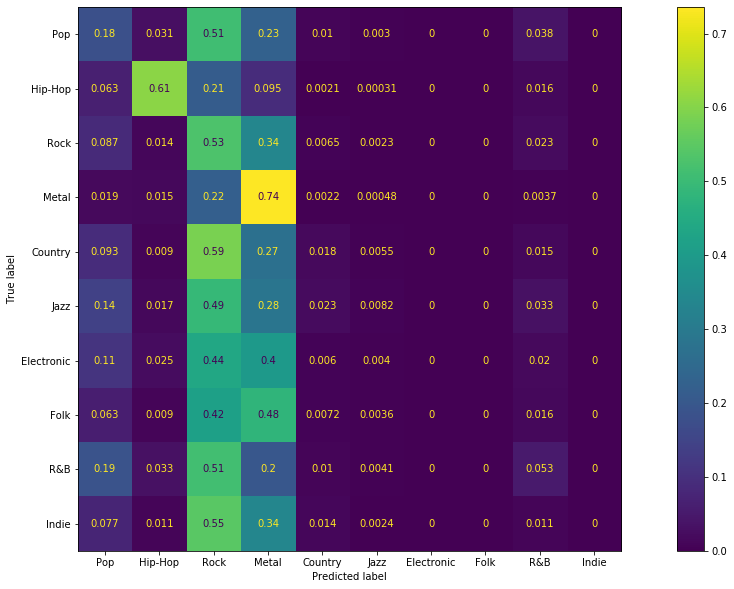

In [25]:
# visualize the confusion matrix
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_clfs['NaiveBayes'][10], test_pca[:,:10], lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_naive_bayes')

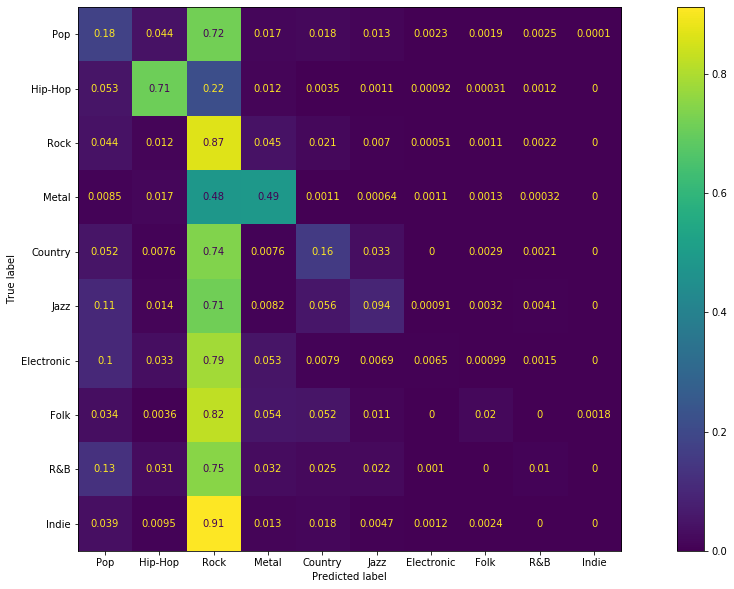

In [26]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_clfs['LogisticRegression'][200], test_pca[:,:200], lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_regression')

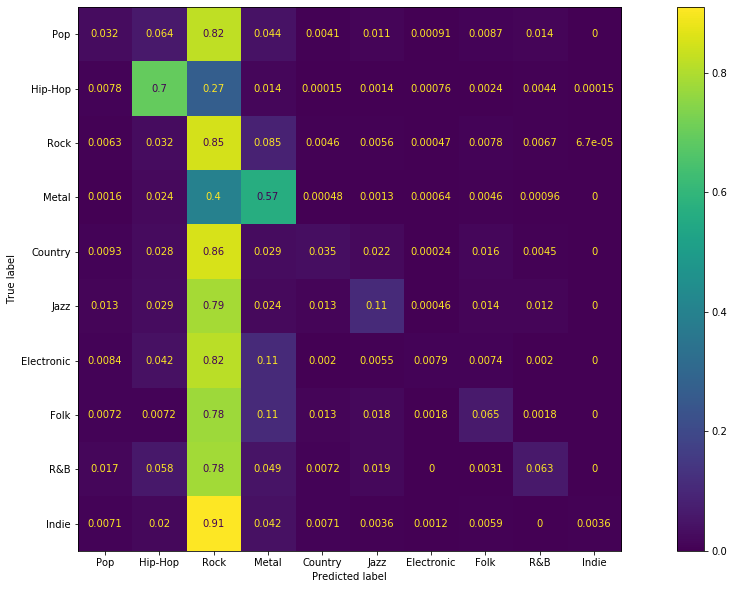

In [27]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_clfs['RandomForest'][100], test_pca[:,:100], lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_random_forest')

## Feature Analysis

In [28]:
lyrics_1_train['tokens'] = lyrics_1_train['lyrics'].apply(lambda x:lucem_illud_2020.word_tokenize(x))
lyrics_1_train['normalized'] = lyrics_1_train['tokens'].apply(
    lambda x:lucem_illud_2020.normalizeTokens(x, extra_stop=['intro','verse','pre','post','lift',
                            'chorus','bridge','outro','instrumental']+[str(i) for i in range(10)]))
lyrics_1_train['normalized']

/home/cytwill/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/cytwill/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


42873     [know, believe, like, get, ta, movie, screen, ...
110420    [come, coast, state, daddy, blue, eye, mama, b...
163646    [someway, bad, blood, speak, know, listen, bad...
123036    [cream, soup, look, mirror, know, be, good, ea...
63852     [soul, flesh, segregate, quest, baptize, raven...
                                ...                        
176963    [bottle, go, drain, hour, waste, time, ask, fe...
117952    [walk, love, walk, minefield, hear, walk, love...
173685    [hard, break, heart, cry, sleep, tonight, lone...
43567     [know, time, come, time, land, sting, abrasion...
199340    [battle, battle, ride, throught, dark, forest,...
Name: normalized, Length: 147449, dtype: object

In [29]:
vocab_freqs = []

for k,index in genre_dict.items():
    df = train_groups[index]
    tdidf = TFVectorizer.transform(df['lyrics']).todense()
    vocab_freqs.append(np.array(tdidf).mean(axis=0))

In [30]:
genre_dict.keys()

dict_keys(['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'])

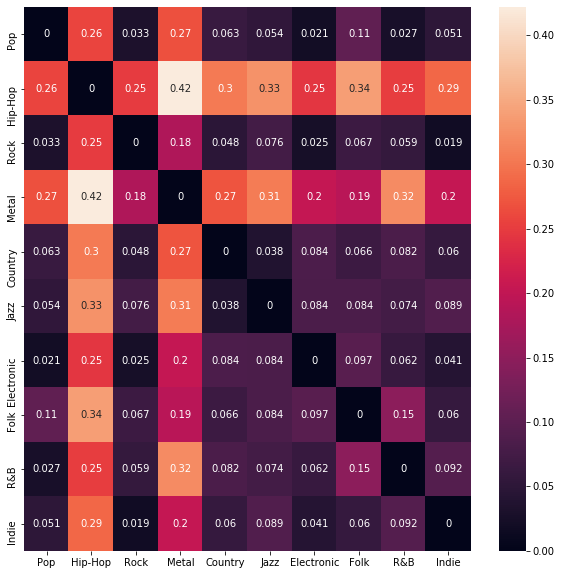

In [31]:
from scipy.spatial.distance import cosine
M = []
for p in vocab_freqs:
    L = []
    for q in vocab_freqs:
        L.append(cosine(p,q))
    M.append(L)
plt.rcParams['figure.figsize'] = [10,10]
sns.heatmap(np.array(M),xticklabels=genre_dict.keys(), 
            yticklabels=genre_dict.keys(), annot=True)
plt.savefig("Pictures/feature word frequency cosine.png", format = 'png')

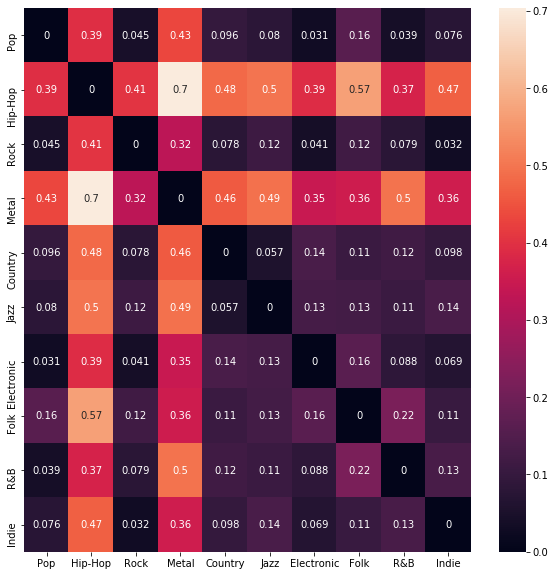

In [32]:
from scipy.spatial.distance import correlation
M = []
for p in vocab_freqs:
    L = []
    for q in vocab_freqs:
        L.append(correlation(p,q))
    M.append(L)

plt.rcParams['figure.figsize'] = [10,10]
sns.heatmap(np.array(M),xticklabels=genre_dict.keys(), 
            yticklabels=genre_dict.keys(), annot=True)
plt.savefig("Pictures/feature word frequency correlation.png", format = 'png')

In [34]:
import joblib
Best_LR = joblib.load('Classification Models/Logistic_Regression_200.joblib')
Best_RF = joblib.load('Classification Models/Random_Forest_100.joblib')

In [35]:
from sklearn.inspection import permutation_importance
train_feature_checking = permutation_importance(Best_LR, train_pca[:,:200], lyrics_1_train['genre'], 
                                          scoring=f1_scorer, n_jobs=-1, random_state=0, n_repeats=10)
train_feature_checking

{'importances_mean': array([ 4.57525993e-02,  6.21289475e-02,  3.79870894e-03,  4.60883250e-02,
         8.93228511e-03,  7.30526768e-03,  7.39843183e-03,  5.38823612e-03,
         1.87682414e-03,  7.78123986e-03,  1.92442747e-03,  1.80096210e-02,
         3.84643031e-03,  4.25320033e-03,  2.96541920e-03,  4.87307614e-04,
         1.51856094e-03,  3.93507101e-03,  3.85993052e-04,  2.37043985e-03,
         1.81648393e-03,  9.16937821e-04,  1.44386454e-03,  8.52140108e-04,
         2.73786438e-03,  2.09733806e-04,  5.17935472e-04,  5.53948892e-04,
         1.37553278e-03,  1.69067410e-03,  3.72564540e-05,  7.24749843e-03,
         1.93875110e-03,  6.64318922e-04,  6.82987673e-04,  6.56052566e-04,
         1.13281237e-03,  9.23338316e-04,  1.26695224e-03,  3.49251261e-04,
        -1.58515227e-04,  9.61533472e-04,  1.10289874e-03,  1.92735253e-03,
         3.05116704e-05,  7.12350967e-04,  1.41271470e-03,  4.58066950e-05,
         4.61745161e-04,  1.80258846e-04,  9.09335727e-04,  1.163988

In [36]:
sorted(enumerate(train_feature_checking['importances_mean']),key=lambda x:x[1],reverse=True)[:10]

[(1, 0.06212894747322815),
 (3, 0.046088324970196874),
 (0, 0.045752599308173846),
 (11, 0.01800962102371928),
 (4, 0.008932285105828075),
 (9, 0.007781239860652644),
 (6, 0.0073984318276410724),
 (5, 0.007305267680483873),
 (31, 0.007247498433429311),
 (7, 0.005388236122312628)]

In [37]:
test_feature_checking = permutation_importance(Best_LR, test_pca[:,:200], lyrics_1_test['genre'], 
                                          scoring=f1_scorer, n_jobs=-1, random_state=0, n_repeats=10)

In [38]:
sorted(enumerate(test_feature_checking['importances_mean']),key=lambda x:x[1],reverse=True)[:10]

[(1, 0.060603918320317016),
 (3, 0.04459555470971823),
 (0, 0.043495171319513776),
 (11, 0.0177292343617081),
 (9, 0.007852463234213824),
 (4, 0.007534446353696189),
 (5, 0.006715975734432611),
 (6, 0.005912019944403835),
 (31, 0.005709362477893054),
 (7, 0.0038785718071775222)]

In [41]:
top_test_importances = sorted(enumerate(test_feature_checking['importances_mean']),key=lambda x:x[1],reverse=True)[:10]
top_PC_ids = [x[0] for x in top_test_importances]
top_test_importances

[(1, 0.060603918320317016),
 (3, 0.04459555470971823),
 (0, 0.043495171319513776),
 (11, 0.0177292343617081),
 (9, 0.007852463234213824),
 (4, 0.007534446353696189),
 (5, 0.006715975734432611),
 (6, 0.005912019944403835),
 (31, 0.005709362477893054),
 (7, 0.0038785718071775222)]

In [42]:
top_PC = pca.components_[top_PC_ids,:]
top_PC

array([[-0.01932653,  0.00648006,  0.00022667, ..., -0.10170897,
        -0.00889496, -0.01194386],
       [ 0.00728555, -0.01854221,  0.00287544, ...,  0.09961348,
         0.01125034,  0.02264028],
       [ 0.00367628,  0.00586962, -0.00861618, ...,  0.01216413,
        -0.00185381, -0.00428052],
       ...,
       [ 0.00265538,  0.0012616 , -0.00205085, ...,  0.05114235,
         0.0022863 ,  0.00152364],
       [ 0.00731526,  0.00589016,  0.00133132, ..., -0.00209285,
        -0.01291032, -0.00879138],
       [-0.00602857, -0.00776146, -0.00129881, ..., -0.01492963,
         0.00167658, -0.00022793]])

In [43]:
# clustering analysis
word_importance = np.average(top_PC, weights=sorted(test_feature_checking['importances_mean'],reverse=True)[:10], axis=0)
word_importance

array([-0.00352347, -0.00023393, -0.00083489, ..., -0.0029977 ,
       -0.00126804, -0.00081626])

In [46]:
top5_word_importance = sorted(enumerate(word_importance),key=lambda x:abs(x[1]),reverse=True)[:5]
top5_word_inds = [x[0] for x in top5_word_importance]
top5_word_inds

[521, 27, 211, 442, 350]

In [47]:
ind2word = {y:x for x,y in TFVectorizer.vocabulary_.items()}

In [48]:
top5_word = [ind2word[i] for i in top5_word_inds]
top5_word

['love', 'baby', 'don', 'just', 'gonna']

In [49]:
top5_tdidf = []
for k,index in genre_dict.items():
    df = train_groups[index]
    tdidf = TFVectorizer.transform(df['lyrics']).todense()
    ave = np.array(tdidf).mean(axis=0)
    top5_tdidf.append(ave[top5_word_inds])
top5_tdidf

[array([0.07681857, 0.04131786, 0.04963794, 0.04102216, 0.02331108]),
 array([0.0317206 , 0.03281968, 0.05605609, 0.04468588, 0.01786961]),
 array([0.04164923, 0.02119978, 0.04568883, 0.03853766, 0.02157474]),
 array([0.01640408, 0.00337901, 0.02392156, 0.02124813, 0.00566001]),
 array([0.0702711 , 0.0226947 , 0.03917689, 0.04536886, 0.02433132]),
 array([0.08760131, 0.03495694, 0.03410498, 0.03879474, 0.01884723]),
 array([0.05333862, 0.02283269, 0.04060798, 0.03344022, 0.0165136 ]),
 array([0.04584018, 0.01037467, 0.02745514, 0.02416811, 0.01226513]),
 array([0.07403902, 0.07070359, 0.05630985, 0.04612936, 0.02460555]),
 array([0.04319199, 0.01084048, 0.04539374, 0.03696991, 0.01744968])]

In [76]:
genre_dict.keys()

dict_keys(['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'])

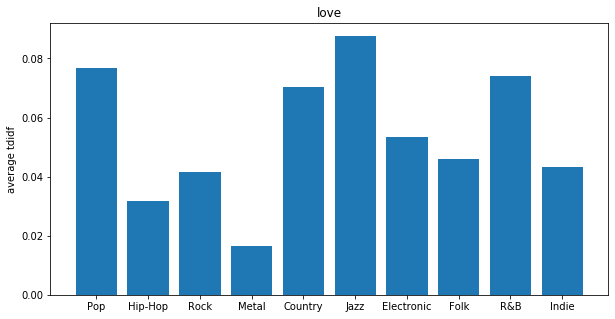

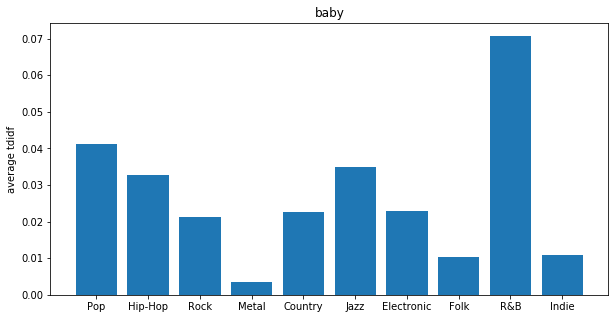

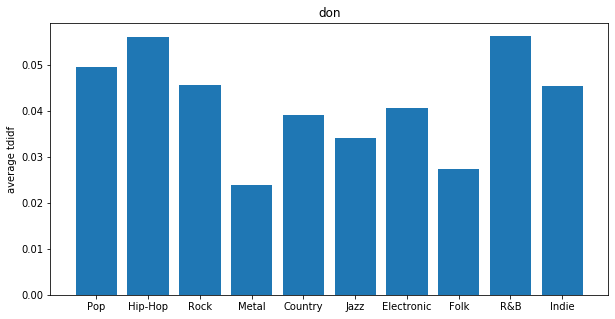

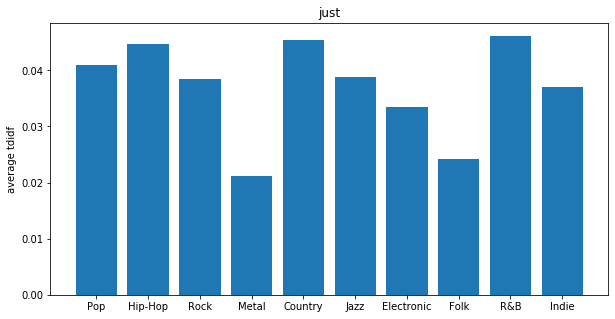

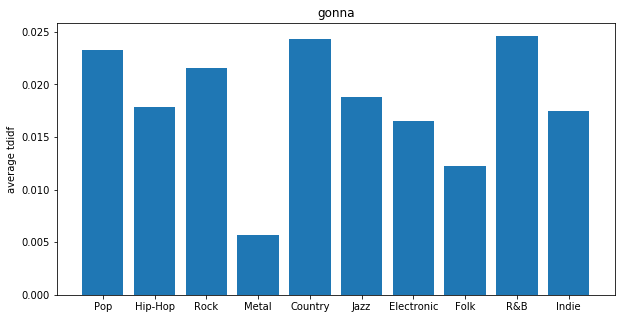

<Figure size 720x360 with 0 Axes>

In [50]:
plt.rcParams['figure.figsize']=[10,5]
for i in range(5):
    plt.bar(genre_dict.keys(), [x[i] for x in top5_tdidf])
    plt.ylabel('average tdidf')
    plt.title(top5_word[i])
    plt.show()
    plt.savefig('Pictures/word_{}_LR.png'.format(top5_word[i]))

# Word-Cloud

In [51]:
hiphop_group = lyrics_1_train.loc[lyrics_1_train['genre']==1]
metal_group = lyrics_1_train.loc[lyrics_1_train['genre']==3]
rock_group = lyrics_1_train.loc[lyrics_1_train['genre']==2]
indie_group = lyrics_1_train.loc[lyrics_1_train['genre']==9]

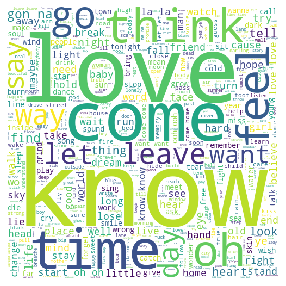

In [52]:
import wordcloud
for df in [hiphop_group,metal_group,rock_group,indie_group]:
    genre = pd.unique(df['genre'])[0]
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(
        ' '.join(df['normalized'].sum()))
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig("Pictures/{}.png".format(genre), format = 'png')

## Similarity Test

In [22]:
sub_df = lyrics_1.loc[lyrics_1['genre'].isin(['Pop','Country','Jazz','Electronic','Folk','R&B','Indie'])]
sub_df

,artist,genre,lyrics
0,beyonce-knowles,Pop,"oh baby, how you doing? you know i'm gonna cut..."
1,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,beyonce-knowles,Pop,if you search for tenderness it isn't hard to ...
3,beyonce-knowles,Pop,"oh oh oh i, oh oh oh i if i wrote a book abo..."
4,beyonce-knowles,Pop,"party the people, the people the party it's po..."
...,...,...,...
210637,edens-edge,Country,"i gotta say boy, after only just a couple of d..."
210638,edens-edge,Country,i helped you find her diamond ring you made me...
210639,edens-edge,Country,look at the couple in the corner booth looks a...
210640,edens-edge,Country,when i fly off this mortal earth and i'm measu...


In [17]:
SubVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.8, min_df=0.001, stop_words=my_stop_words, norm='l2')
sub_vects = SubVectorizer.fit_transform(sub_df['lyrics'])
sub_vects.shape

(35811, 4482)

In [18]:
sub_groups = dict(list(sub_df.groupby(['genre'])))

In [19]:
sub_freqs = []

for k in ['Country','Jazz','Electronic','Folk','R&B','Indie']:
    df = sub_groups[k]
    tdidf = SubVectorizer.transform(df['lyrics']).todense()
    sub_freqs.append(np.array(tdidf).mean(axis=0))

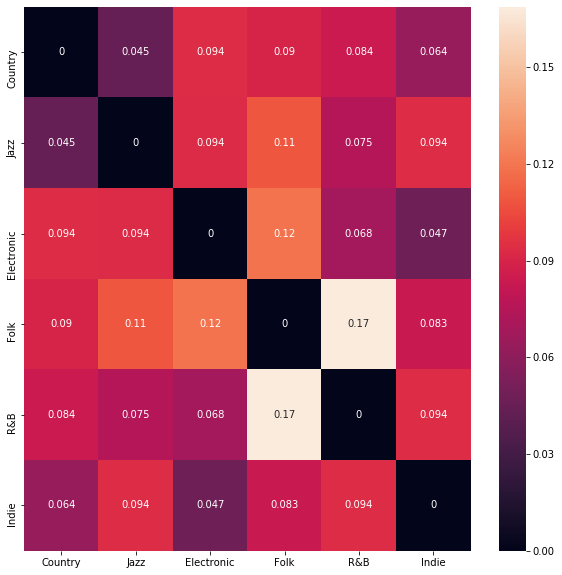

In [21]:
from scipy.spatial.distance import cosine
M = []
for p in sub_freqs:
    L = []
    for q in sub_freqs:
        L.append(cosine(p,q))
    M.append(L)
plt.rcParams['figure.figsize'] = [10,10]
sns.heatmap(np.array(M),xticklabels=['Country','Jazz','Electronic','Folk','R&B','Indie'], 
            yticklabels=['Country','Jazz','Electronic','Folk','R&B','Indie'], annot=True)
#plt.savefig("Pictures 2/feature word frequency cosine-sub.png", format = 'png')